In [1]:
from functools import partial

import jax
import jax.numpy as jnp
import jax.random as random

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive

import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs
from spamr import Priors, make_spamr, make_mixture_regression

numpyro.set_platform("cpu")
numpyro.enable_x64(True)

@partial(jax.jit, static_argnames=['n_clust'])
def get_clust_proportions(assignments, n_clust):
    """
    Get the proportion of MCMC samples each row was assigned to each
    cluster. 

    Args:
        assignments: `(n_samples, n_obs)` array of cluster indeces for each row
        n_clust (int): number of clusters fit with
    
    Returns:
        `(n_obs, n_clust)` array of cluster assignment proportions 
    """
    
    def single_row_clust_proportions(assignments, n_clust):
        clusters = jnp.arange(n_clust)[..., jnp.newaxis]
        return jnp.sum((assignments == clusters), axis=1) / len(assignments)

    return jax.vmap(single_row_clust_proportions, 
                    in_axes=(1, None))(assignments, n_clust)

Generate data:

In [2]:
n_samples = 100
n_features = 3

_, true_labels, cluster_centers = make_blobs(n_samples=n_samples, 
                                             n_features=n_features,
                                             shuffle=False,
                                             centers=jnp.array([[-3., -3., -3.],
                                                                [1., 1., 1.], 
                                                                [3., 3., 3.]]),
                                             return_centers=True,
                                             random_state=0)
true_betas = cluster_centers[true_labels]

x_key, y_key, mcmc_key = random.split(random.PRNGKey(0), 3)
X = jnp.concatenate([jnp.ones((n_samples, 1)), 
                     random.normal(x_key, (n_samples, n_features - 1))], axis=-1)

Y = jnp.sum(X * true_betas, axis=1, keepdims=True) + random.normal(y_key, (n_samples, 1))


Plot the latent structure we want to recover:

Text(0.5, 1.0, 'True Clustering')

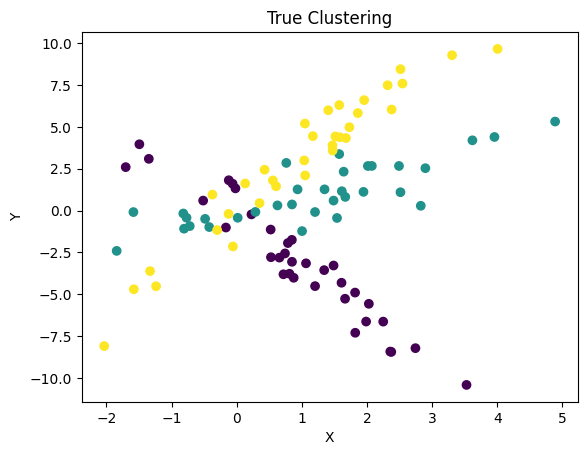

In [11]:
plt.scatter(jnp.sum(X, axis=-1), Y, c=true_labels)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('True Clustering')

We can either create a spamr model or use the lower-level `make_mixture_regression` API to build custom mixture regression models. Here, we'll make a standard spamr regression model.

In [4]:
spamr = make_spamr(X, Y)

In [6]:
mcmc = MCMC(NUTS(spamr), num_warmup=1000, num_samples=1000)
mcmc.run(mcmc_key, X, Y=Y)

sample: 100%|██████████| 2000/2000 [00:17<00:00, 114.29it/s, 255 steps of size 1.98e-02. acc. prob=0.87]


Analyze the results with tools from NumPyro.

In [7]:
samples = mcmc.get_samples()
predictive = Predictive(spamr, posterior_samples=samples, infer_discrete=True)
predictions = predictive(random.PRNGKey(0), X, Y=Y)

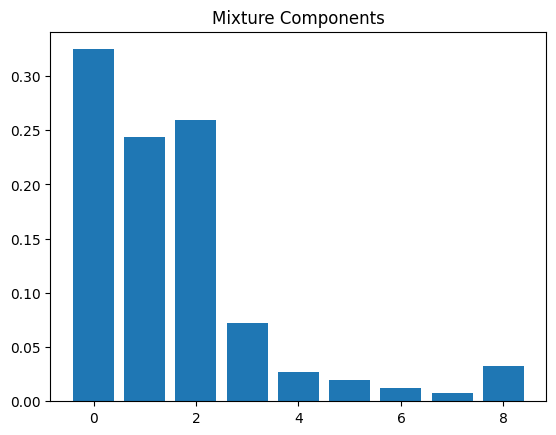

In [8]:
mixture_weights = jnp.mean(samples['mixture_weights'], axis=0)

plt.bar(x=jnp.arange(len(mixture_weights)), height=mixture_weights)
plt.title("Mixture Components");

Text(0.5, 1.0, 'Predicted Clustering')

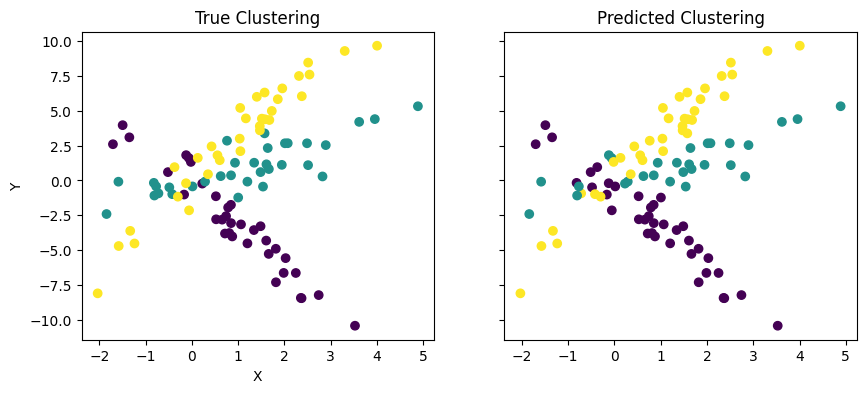

In [21]:
clust_proportions = get_clust_proportions(predictions['clust_idx'].squeeze(),
                                          n_clust=len(mixture_weights))
argmax_clustering = jnp.argmax(clust_proportions, axis=1)

fig, axs = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(10, 4))

axs[0].scatter(jnp.sum(X, axis=-1), Y, c=true_labels)
axs[0].set_title('True Clustering')
axs[0].set_xlabel('X')
axs[0].set_ylabel('Y')

axs[1].scatter(jnp.sum(X, axis=-1), Y, c=argmax_clustering)
axs[1].set_title('Predicted Clustering')